# Parameter Histograms

This notebook loads a model and draws the histograms of the parameters tensors.

In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable
import scipy.stats as ss

# Relative import of code from distiller, w/o installing the package
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import distiller
import models
from apputils import *

plt.style.use('seaborn') # pretty matplotlib plots

## Load your model

In [ ]:
# It is interesting to compare the distribution of non-pretrained model (Normally-distributed)
# vs. the distribution of the pretrained model.
model = models.create_model(pretrained=True, dataset='imagenet', arch='resnet50', parallel=True)

# Optionally load your compressed model 
# load_checkpoint(model, <path-to-your-checkpoint-file>);

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/vnaveen0/.torch/models/resnet50-19c8e357.pth
100.0%


## Plot the distributions

We plot the distributions of the weights of each convolution layer, and we also plot the fitted Gaussian and Laplacian distributions.

/media/vnaveen0/Windows/Users/naveen/wind_drive/sfu/compression/distiller/env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


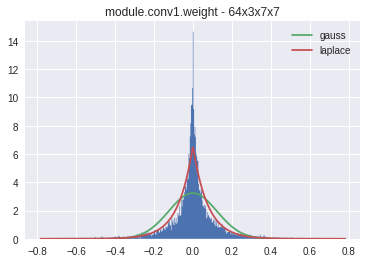

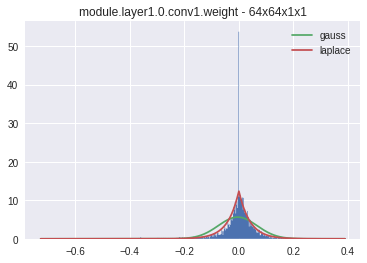

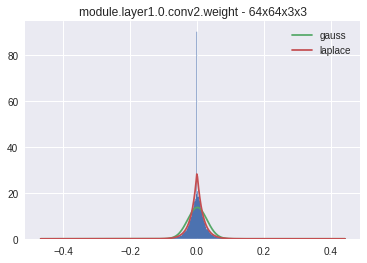

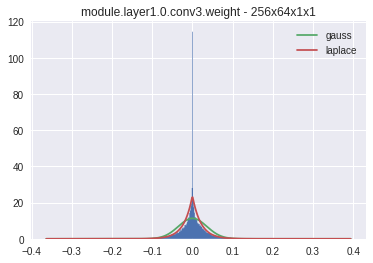

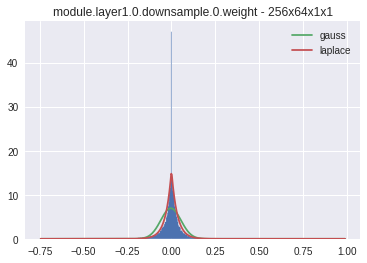

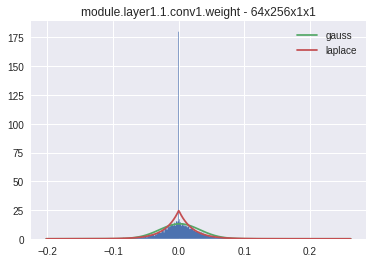

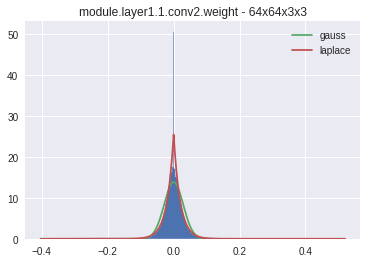

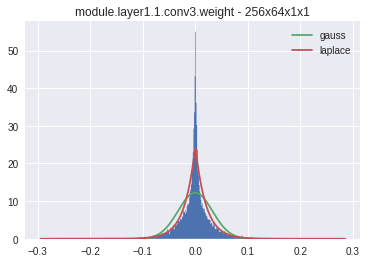

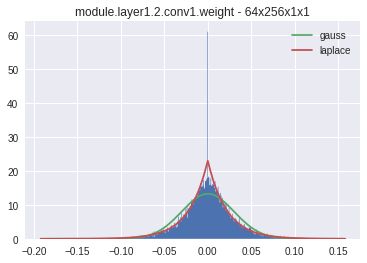

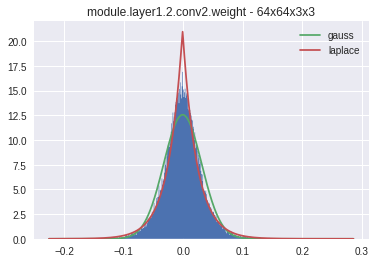

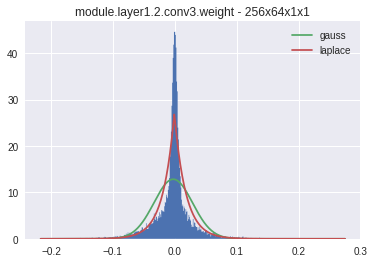

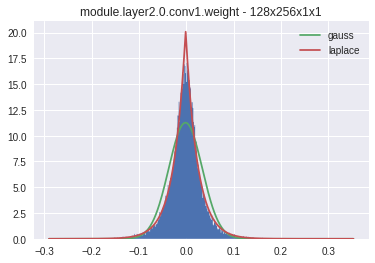

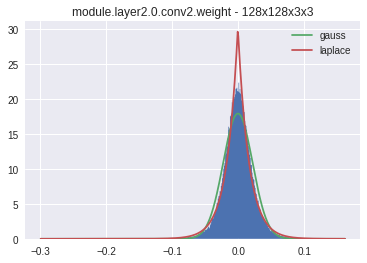

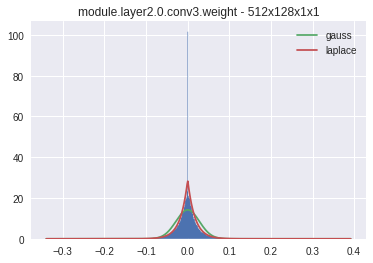

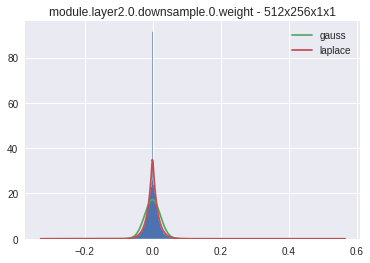

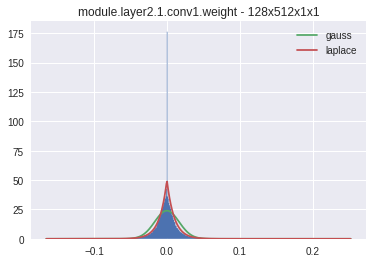

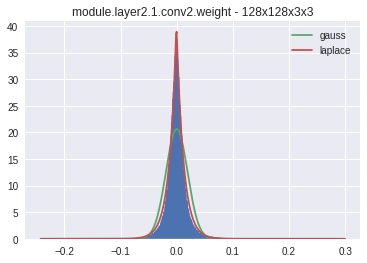

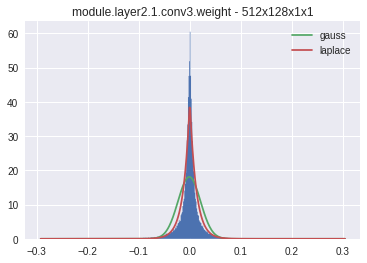

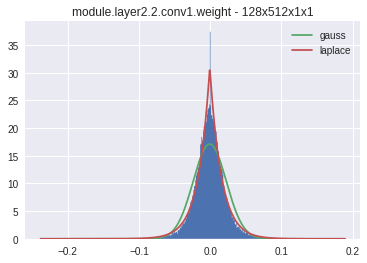

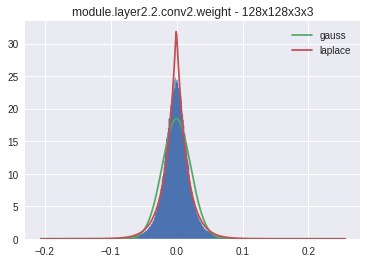

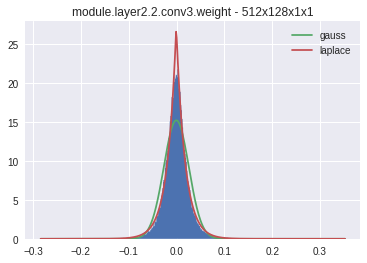

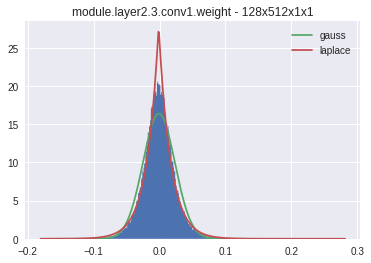

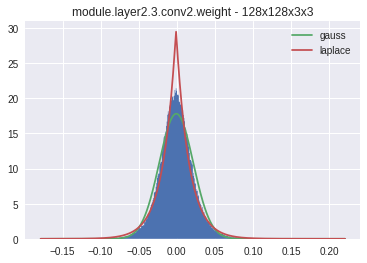

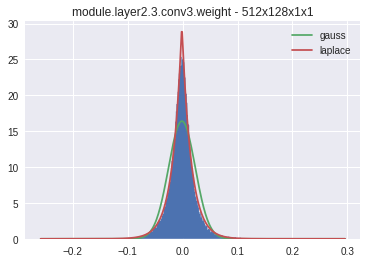

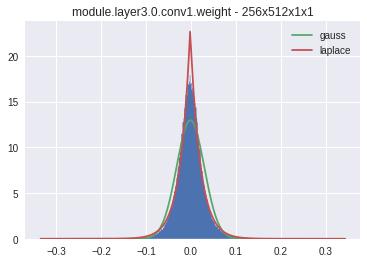

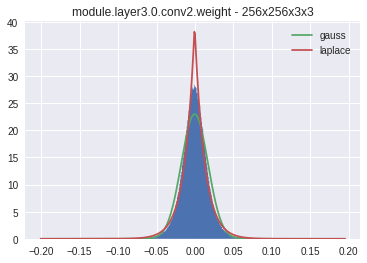

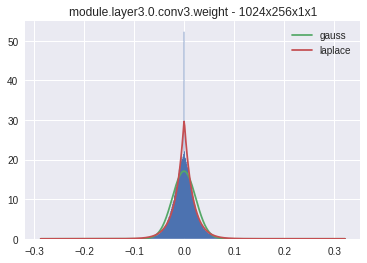

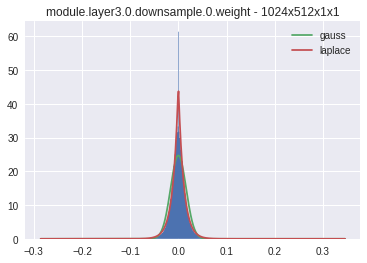

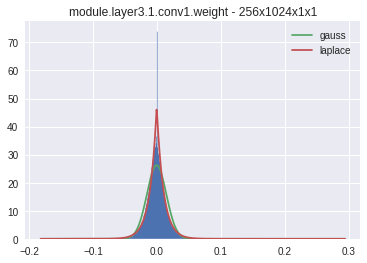

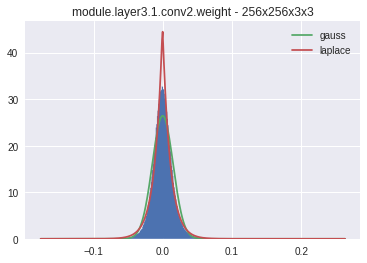

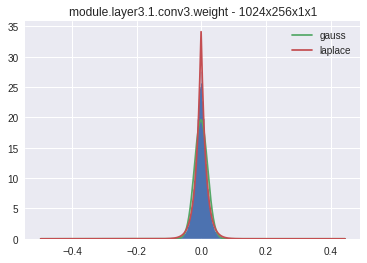

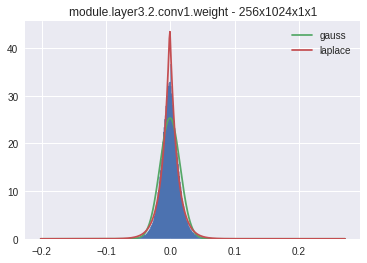

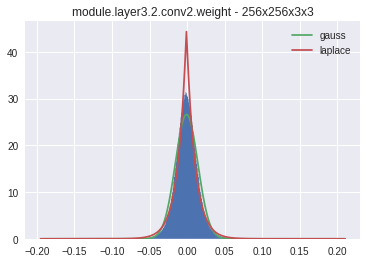

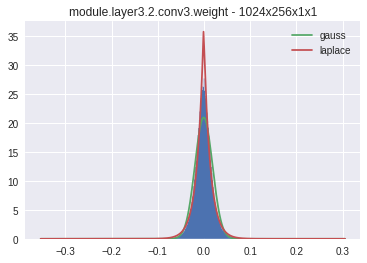

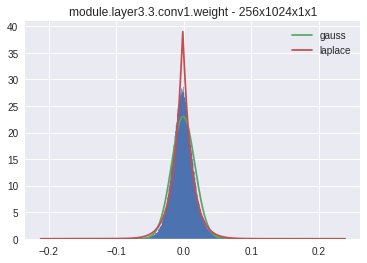

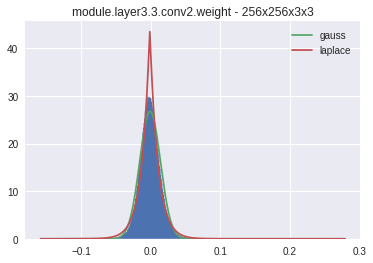

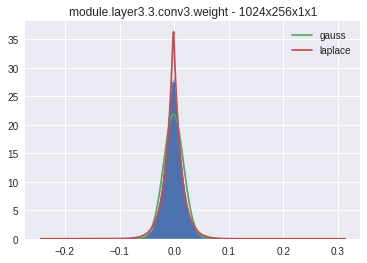

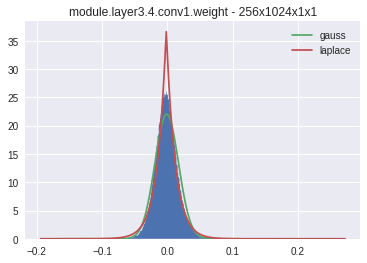

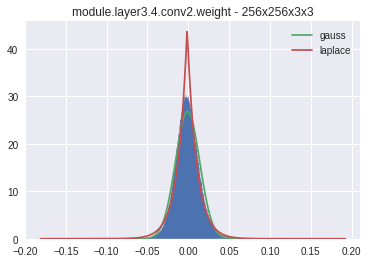

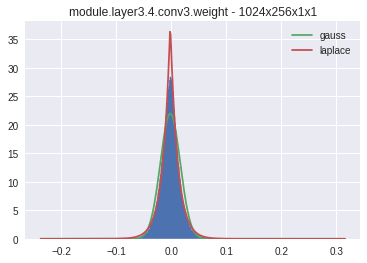

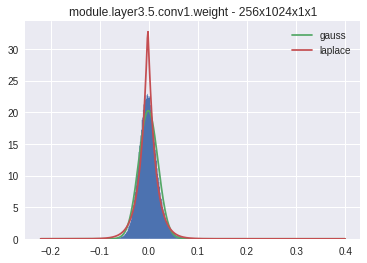

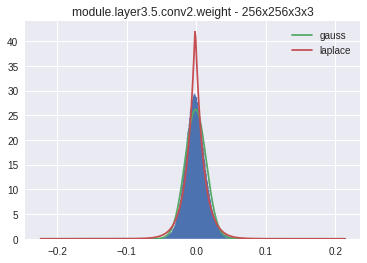

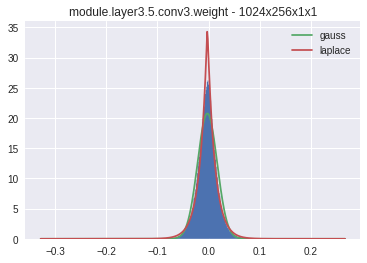

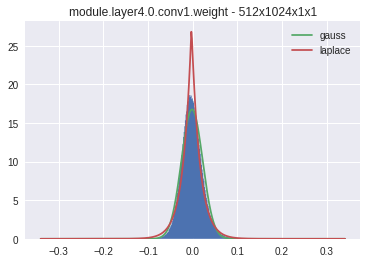

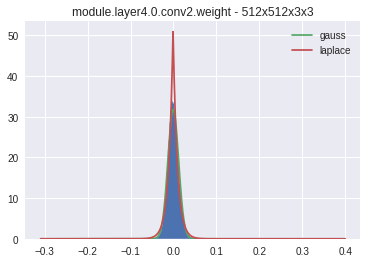

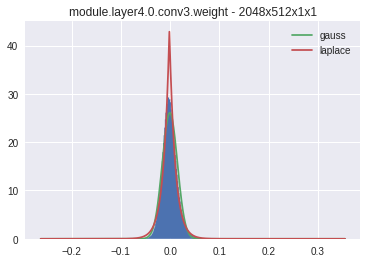

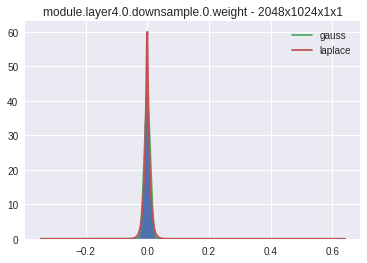

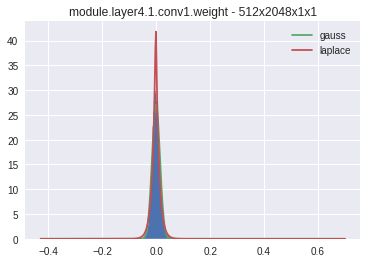

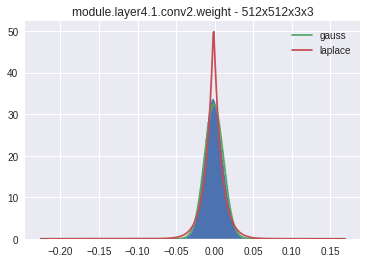

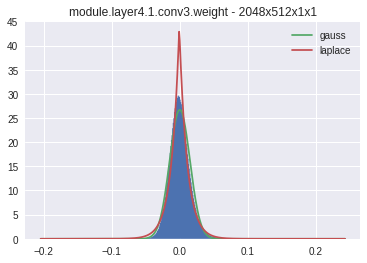

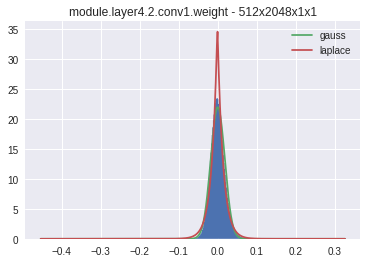

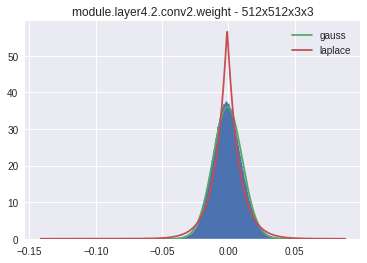

In [ ]:
def flatten(weights):
    weights = weights.view(weights.numel())
    weights = weights.data.cpu().numpy()
    return weights

REMOVE_ZEROS = False
nbins = 500
for name, weights in model.named_parameters():
    if weights.dim() == 4:
        size_str = "x".join([str(s) for s in weights.size()])
        weights = flatten(weights)
        
        if REMOVE_ZEROS:
            # Optionally remove zeros (lots of zeros will dominate the histogram and the 
            # other data will be hard to see
            weights = weights[weights!=0]
        
        # Fit the data to the Normal distribution
        (mean_fitted, std_fitted) = ss.norm.fit(weights)
        x = np.linspace(min(weights), max(weights), nbins)
        weights_gauss_fitted = ss.norm.pdf(x, loc=mean_fitted, scale=std_fitted)

        # Fit the data to the Laplacian distribution
        (mean_fitted, std_fitted) = ss.laplace.fit(weights)
        weights_laplace_fitted = ss.laplace.pdf(x, loc=mean_fitted, scale=std_fitted)

        n, bins, patches = plt.hist(weights, histtype='stepfilled', 
                                    cumulative=False, bins=nbins, normed=1)
        plt.plot(x, weights_gauss_fitted, label='gauss')
        plt.plot(x, weights_laplace_fitted, label='laplace')
        plt.title(name + " - " +size_str)
        #plt.figure(figsize=(10,5))
        plt.legend()
        plt.show()